In [ ]:
!pip install PyDrive

In [1]:
import mykeys

mykeys.setOsEnv()

아래 링크를 복사하여 웹 브라우저에 붙여넣으세요.
https://accounts.google.com/o/oauth2/auth?client_id=35726703810-4v13dfqmilhgv6shlc3cv9i3ktuh73j1.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&access_type=offline&response_type=code
Authentication successful.
mykey => set HUGGINGFACEHUB_API_TOKEN is done
mykey => set OPENAI_API_KEY is done
mykey => set LANGCHAIN_API_KEY is done
mykey => set LANGCHAIN_HUB_API_KEY is done
mykey => set GOOGLE_API_KEY is done
mykey => set UPSTAGE_API_KEY is done
mykey => set COHERE_API_KEY is done
mykey => set JINA_API_KEY is done
mykey => set ANTHROPIC_API_KEY is done
mykey => set DEEPL_API_KEY is done
mykey => set TAVILY_API_KEY is done
mykey => set TOGETHER_API_KEY is done


In [2]:
import os

project_name = 'CH17_LangGraph_SUB01'

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"] = project_name

In [3]:
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith(project_name)

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17_LangGraph_SUB01


In [ ]:
from langchain_teddynote import logging

# set_enable=False 로 지정하면 추적을 하지 않습니다.
logging.langsmith(project_name, set_enable=False)

CH17 LangGraph

01. 핵심 기능

08. 사람(Human)에게 물어보는 노드 추가

In [4]:
from typing import Annotated
from typing_extensions import TypedDict
from langchain_teddynote.tools.tavily import TavilySearch
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


In [5]:
class State(TypedDict):
    # 메시지 목록
    messages: Annotated[list, add_messages]
    # 사람에게 질문할지 여부를 묻는 상태 추가
    ask_human: bool


In [6]:
from pydantic import BaseModel


class HumanRequest(BaseModel):
    """Forward the conversation to an expert. Use when you can't assist directly or the user needs assistance that exceeds your authority.
    To use this function, pass the user's 'request' so that an expert can provide appropriate guidance.
    """

    request: str


In [7]:
from langchain_openai import ChatOpenAI

# 도구 추가
tool = TavilySearch(max_results=3)

# 도구 목록 추가(HumanRequest 도구)
tools = [tool, HumanRequest]

# LLM 추가
llm = ChatOpenAI(model="gpt-4.1", temperature=0)

# 도구 바인딩
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    # LLM 도구 호출을 통한 응답 생성
    response = llm_with_tools.invoke(state["messages"])

    # 사람에게 질문할지 여부 초기화
    ask_human = False

    # 도구 호출이 있고 이름이 'HumanRequest' 인 경우
    if response.tool_calls and response.tool_calls[0]["name"] == HumanRequest.__name__:
        ask_human = True

    # 메시지와 ask_human 상태 반환
    return {"messages": [response], "ask_human": ask_human}


In [8]:
# 상태 그래프 초기화
graph_builder = StateGraph(State)

# 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)

# 도구 노드 추가
graph_builder.add_node("tools", ToolNode(tools=[tool]))


In [9]:
from langchain_core.messages import AIMessage, ToolMessage


# 응답 메시지 생성(ToolMessage 생성을 위한 함수)
def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


# 인간 노드 처리
def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        # 사람으로부터 응답이 없는 경우
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # 새 메시지 추가
        "messages": new_messages,
        # 플래그 해제
        "ask_human": False,
    }


# 그래프에 인간 노드 추가
graph_builder.add_node("human", human_node)


In [10]:
from langgraph.graph import END


# 다음 노드 선택
def select_next_node(state: State):
    # 인간에게 질문 여부 확인
    if state["ask_human"]:
        return "human"
    # 이전과 동일한 경로 설정
    return tools_condition(state)


# 조건부 엣지 추가
graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)


In [11]:
# 엣지 추가: 'tools'에서 'chatbot'으로
graph_builder.add_edge("tools", "chatbot")

# 엣지 추가: 'human'에서 'chatbot'으로
graph_builder.add_edge("human", "chatbot")

# 엣지 추가: START에서 'chatbot'으로
graph_builder.add_edge(START, "chatbot")

# 메모리 저장소 초기화
memory = MemorySaver()

# 그래프 컴파일: 메모리 체크포인터 사용
graph = graph_builder.compile(
    checkpointer=memory,
    # 'human' 이전에 인터럽트 설정
    interrupt_before=["human"],
)


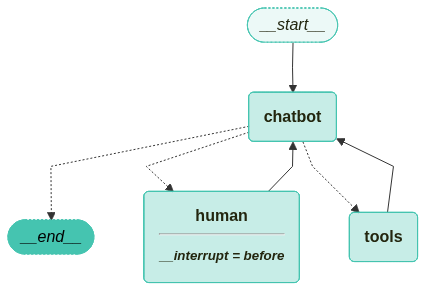

In [12]:
from langchain_teddynote.graphs import visualize_graph

# 그래프 시각화
visualize_graph(graph)

In [13]:
# user_input = "이 AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다. 검색해서 답변하세요" (Human 이 아닌 웹검색을 수행하는 경우)
user_input = "이 AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다. 도움을 요청할 수 있나요?"

# config 설정
config = {"configurable": {"thread_id": "1"}}

# 스트림 또는 호출의 두 번째 위치 인수로서의 구성
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    if "messages" in event:
        # 마지막 메시지의 예쁜 출력
        event["messages"][-1].pretty_print()


================================ Human Message =================================

이 AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다. 도움을 요청할 수 있나요?
================================== Ai Message ==================================
Tool Calls:
  HumanRequest (call_5KhRIpj5g9o2Y7mbshwue20L)
 Call ID: call_5KhRIpj5g9o2Y7mbshwue20L
  Args:
    request: 이 AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다. 전문가의 도움을 요청합니다.


In [14]:
# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)

# 다음 스냅샷 상태 접근
snapshot.next


('human',)

In [15]:
# AI 메시지 추출
ai_message = snapshot.values["messages"][-1]

# 인간 응답 생성
human_response = (
    "전문가들이 도와드리겠습니다! 에이전트 구축을 위해 LangGraph를 확인해 보시기를 적극 추천드립니다. "
    "단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. "
    "https://wikidocs.net/233785 에서 더 많은 정보를 확인할 수 있습니다."
)

# 도구 메시지 생성
tool_message = create_response(human_response, ai_message)

# 그래프 상태 업데이트
graph.update_state(config, {"messages": [tool_message]})


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f083a45-332f-6ee8-8002-d86b4a40b050'}}

In [16]:
# 그래프 상태에서 메시지 값 가져오기
graph.get_state(config).values["messages"]


[HumanMessage(content='이 AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다. 도움을 요청할 수 있나요?', additional_kwargs={}, response_metadata={}, id='fb423ebc-4abf-474a-a163-655351bd87e5'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5KhRIpj5g9o2Y7mbshwue20L', 'function': {'arguments': '{"request":"이 AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다. 전문가의 도움을 요청합니다."}', 'name': 'HumanRequest'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 171, 'total_tokens': 207, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_daf5fcc80a', 'id': 'chatcmpl-C9Kb2soS06phsOBBGgPWpYtYrmNOc', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--afdb4e75-a2fc-4c18-bc5d-f7c70b65d863-0', tool_calls=[{'name': '

In [17]:
# 그래프에서 이벤트 스트림 생성
events = graph.stream(None, config, stream_mode="values")

# 각 이벤트에 대한 처리
for event in events:
    # 메시지가 있는 경우 마지막 메시지 출력
    if "messages" in event:
        event["messages"][-1].pretty_print()


================================= Tool Message =================================

전문가들이 도와드리겠습니다! 에이전트 구축을 위해 LangGraph를 확인해 보시기를 적극 추천드립니다. 단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. https://wikidocs.net/233785 에서 더 많은 정보를 확인할 수 있습니다.
================================= Tool Message =================================

전문가들이 도와드리겠습니다! 에이전트 구축을 위해 LangGraph를 확인해 보시기를 적극 추천드립니다. 단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. https://wikidocs.net/233785 에서 더 많은 정보를 확인할 수 있습니다.
================================== Ai Message ==================================

전문가의 안내에 따라, AI 에이전트 구축을 위해 LangGraph를 확인해 보시는 것이 좋습니다. LangGraph는 단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어난 프레임워크입니다.

더 자세한 정보와 실습 예제는 아래 링크에서 확인하실 수 있습니다:
- LangGraph 소개 및 활용법: https://wikidocs.net/233785

추가적으로 궁금한 점이나 구체적인 구현에 대한 질문이 있으시면 언제든 말씀해 주세요!


In [18]:
# 최종 상태 확인
state = graph.get_state(config)

# 단계별 메시지 출력
for message in state.values["messages"]:
    message.pretty_print()


================================ Human Message =================================

이 AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다. 도움을 요청할 수 있나요?
================================== Ai Message ==================================
Tool Calls:
  HumanRequest (call_5KhRIpj5g9o2Y7mbshwue20L)
 Call ID: call_5KhRIpj5g9o2Y7mbshwue20L
  Args:
    request: 이 AI 에이전트를 구축하기 위해 전문가의 도움이 필요합니다. 전문가의 도움을 요청합니다.
================================= Tool Message =================================

전문가들이 도와드리겠습니다! 에이전트 구축을 위해 LangGraph를 확인해 보시기를 적극 추천드립니다. 단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어납니다. https://wikidocs.net/233785 에서 더 많은 정보를 확인할 수 있습니다.
================================== Ai Message ==================================

전문가의 안내에 따라, AI 에이전트 구축을 위해 LangGraph를 확인해 보시는 것이 좋습니다. LangGraph는 단순한 자율 에이전트보다 훨씬 더 안정적이고 확장성이 뛰어난 프레임워크입니다.

더 자세한 정보와 실습 예제는 아래 링크에서 확인하실 수 있습니다:
- LangGraph 소개 및 활용법: https://wikidocs.net/233785

추가적으로 궁금한 점이나 구체적인 구현에 대한 질문이 있으시면 언제든 말씀해 주세요!


09. 메시지 삭제(RemoveMessage)

In [19]:
from typing import Literal

from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

# 체크포인트 저장을 위한 메모리 객체 초기화
memory = MemorySaver()


# 웹 검색 기능을 모방하는 도구 함수 정의
@tool
def search(query: str):
    """Call to surf on the web."""
    return "웹 검색 결과: LangGraph 한글 튜토리얼은 https://wikidocs.net/233785 에서 확인할 수 있습니다."


# 도구 목록 생성 및 도구 노드 초기화
tools = [search]
tool_node = ToolNode(tools)

# 모델 초기화 및 도구 바인딩
model = ChatOpenAI(model_name="gpt-4.1")
bound_model = model.bind_tools(tools)


# # 대화 상태에 따른 다음 실행 노드 결정 함수
def should_continue(state: MessagesState):
    last_message = state["messages"][-1]
    if not last_message.tool_calls:
        return END
    return "tool"


# LLM 모델 호출 및 응답 처리 함수
def call_model(state: MessagesState):
    response = model.invoke(state["messages"])
    return {"messages": response}


# 상태 기반 워크플로우 그래프 초기화
workflow = StateGraph(MessagesState)

# 에이전트와 액션 노드 추가
workflow.add_node("agent", call_model)
workflow.add_node("tool", tool_node)

# 시작점을 에이전트 노드로 설정
workflow.add_edge(START, "agent")

# 조건부 엣지 설정: 에이전트 노드 이후의 실행 흐름 정의
workflow.add_conditional_edges("agent", should_continue, {"tool": "tool", END: END})

# 도구 실행 후 에이전트로 돌아가는 엣지 추가
workflow.add_edge("tool", "agent")

# 체크포인터가 포함된 최종 실행 가능한 워크플로우 컴파일
app = workflow.compile(checkpointer=memory)


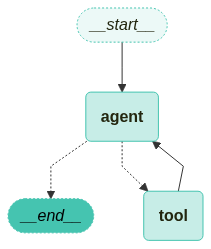

In [20]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)


In [21]:
from langchain_core.messages import HumanMessage

# 스레드 ID가 1인 기본 설정 객체 초기화
config = {"configurable": {"thread_id": "1"}}

# 1번째 질문 수행
input_message = HumanMessage(
    content="안녕하세요! 제 이름은 Charlie입니다. 잘 부탁드립니다."
)

# 스트림 모드로 메시지 처리 및 응답 출력, 마지막 메시지의 상세 정보 표시
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()


================================ Human Message =================================

안녕하세요! 제 이름은 Charlie입니다. 잘 부탁드립니다.
================================== Ai Message ==================================

안녕하세요, Charlie님! 만나서 반갑습니다. 무엇을 도와드릴까요? 궁금한 점이나 필요한 것이 있으시면 언제든 말씀해 주세요. 잘 부탁드립니다! 😊


In [22]:
# 후속 질문 수행
input_message = HumanMessage(content="내 이름이 뭐라고요?")

# 스트림 모드로 두 번째 메시지 처리 및 응답 출력
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()


================================ Human Message =================================

내 이름이 뭐라고요?
================================== Ai Message ==================================

Charlie라고 하셨죠! Charlie님, 또 궁금한 점 있으시면 언제든 말씀해 주세요. 😊


In [23]:
# 단계별 상태 확인
messages = app.get_state(config).values["messages"]
for message in messages:
    message.pretty_print()


================================ Human Message =================================

안녕하세요! 제 이름은 Charlie입니다. 잘 부탁드립니다.
================================== Ai Message ==================================

안녕하세요, Charlie님! 만나서 반갑습니다. 무엇을 도와드릴까요? 궁금한 점이나 필요한 것이 있으시면 언제든 말씀해 주세요. 잘 부탁드립니다! 😊
================================ Human Message =================================

내 이름이 뭐라고요?
================================== Ai Message ==================================

Charlie라고 하셨죠! Charlie님, 또 궁금한 점 있으시면 언제든 말씀해 주세요. 😊


In [25]:
from langchain_core.messages import RemoveMessage

# 메시지 배열의 첫 번째 메시지를 ID 기반으로 제거하고 앱 상태 업데이트
app.update_state(config, {"messages": RemoveMessage(id=messages[0].id)})



{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f083a4d-10f7-631e-8005-dc3785d54986'}}

In [26]:
# 앱 상태에서 메시지 목록 추출 및 저장된 대화 내역 조회
messages = app.get_state(config).values["messages"]
for message in messages:
    message.pretty_print()


================================== Ai Message ==================================

안녕하세요, Charlie님! 만나서 반갑습니다. 무엇을 도와드릴까요? 궁금한 점이나 필요한 것이 있으시면 언제든 말씀해 주세요. 잘 부탁드립니다! 😊
================================ Human Message =================================

내 이름이 뭐라고요?
================================== Ai Message ==================================

Charlie라고 하셨죠! Charlie님, 또 궁금한 점 있으시면 언제든 말씀해 주세요. 😊


In [27]:
from langchain_core.messages import RemoveMessage
from langgraph.graph import END


# 메시지 개수가 3개 초과 시 오래된 메시지 삭제 및 최신 메시지만 유지
def delete_messages(state):
    messages = state["messages"]
    if len(messages) > 3:
        return {"messages": [RemoveMessage(id=m.id) for m in messages[:-3]]}


# 메시지 상태에 따른 다음 실행 노드 결정 로직
def should_continue(state: MessagesState) -> Literal["action", "delete_messages"]:
    """Return the next node to execute."""
    last_message = state["messages"][-1]
    # 함수 호출이 없는 경우 메시지 삭제 함수 실행
    if not last_message.tool_calls:
        return "delete_messages"
    # 함수 호출이 있는 경우 액션 실행
    return "action"


# 메시지 상태 기반 워크플로우 그래프 정의
workflow = StateGraph(MessagesState)

# 에이전트와 액션 노드 추가
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# 메시지 삭제 노드 추가
workflow.add_node(delete_messages)

# 시작 노드에서 에이전트 노드로 연결
workflow.add_edge(START, "agent")

# 조건부 엣지 추가를 통한 노드 간 흐름 제어
workflow.add_conditional_edges(
    "agent",
    should_continue,
)

# 액션 노드에서 에이전트 노드로 연결
workflow.add_edge("action", "agent")

# 메시지 삭제 노드에서 종료 노드로 연결
workflow.add_edge("delete_messages", END)

# 메모리 체크포인터를 사용하여 워크플로우 컴파일
app = workflow.compile(checkpointer=memory)


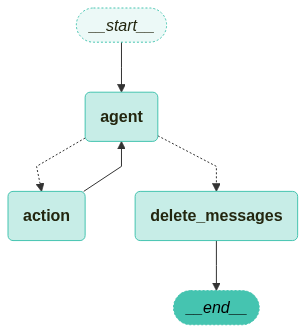

In [28]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)


In [29]:
# LangChain 메시지 처리를 위한 HumanMessage 클래스 임포트
from langchain_core.messages import HumanMessage

# 스레드 ID가 포함된 설정 객체 초기화
config = {"configurable": {"thread_id": "2"}}

# 1번째 질문 수행
input_message = HumanMessage(
    content="안녕하세요! 제 이름은 Charlie입니다. 잘 부탁드립니다."
)
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    print([(message.type, message.content) for message in event["messages"]])


[('human', '안녕하세요! 제 이름은 Charlie입니다. 잘 부탁드립니다.')]
[('human', '안녕하세요! 제 이름은 Charlie입니다. 잘 부탁드립니다.'), ('ai', '안녕하세요, Charlie님! 만나서 반갑습니다. 무엇을 도와드릴까요? 궁금한 점이나 필요한 것이 있으시면 언제든 말씀해 주세요. 잘 부탁드립니다! 😊')]


In [30]:
# 2번째 질문 수행
input_message = HumanMessage(content="내 이름이 뭐라고요?")

for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    print([(message.type, message.content) for message in event["messages"]])


[('human', '안녕하세요! 제 이름은 Charlie입니다. 잘 부탁드립니다.'), ('ai', '안녕하세요, Charlie님! 만나서 반갑습니다. 무엇을 도와드릴까요? 궁금한 점이나 필요한 것이 있으시면 언제든 말씀해 주세요. 잘 부탁드립니다! 😊'), ('human', '내 이름이 뭐라고요?')]
[('human', '안녕하세요! 제 이름은 Charlie입니다. 잘 부탁드립니다.'), ('ai', '안녕하세요, Charlie님! 만나서 반갑습니다. 무엇을 도와드릴까요? 궁금한 점이나 필요한 것이 있으시면 언제든 말씀해 주세요. 잘 부탁드립니다! 😊'), ('human', '내 이름이 뭐라고요?'), ('ai', '당신의 이름은 **Charlie**입니다.')]
[('ai', '안녕하세요, Charlie님! 만나서 반갑습니다. 무엇을 도와드릴까요? 궁금한 점이나 필요한 것이 있으시면 언제든 말씀해 주세요. 잘 부탁드립니다! 😊'), ('human', '내 이름이 뭐라고요?'), ('ai', '당신의 이름은 **Charlie**입니다.')]


In [31]:
# 앱 상태에서 메시지 목록 추출 및 저장
messages = app.get_state(config).values["messages"]
# 메시지 목록 반환
for message in messages:
    message.pretty_print()


================================== Ai Message ==================================

안녕하세요, Charlie님! 만나서 반갑습니다. 무엇을 도와드릴까요? 궁금한 점이나 필요한 것이 있으시면 언제든 말씀해 주세요. 잘 부탁드립니다! 😊
================================ Human Message =================================

내 이름이 뭐라고요?
================================== Ai Message ==================================

당신의 이름은 **Charlie**입니다.


10. ToolNode 를 사용하여 도구를 호출하는 방법

In [33]:
!pip install langchain_experimental

  Using cached langchain_experimental-0.3.4-py3-none-any.whl.metadata (1.7 kB)
  Using cached aiohttp-3.12.15-cp310-cp310-macosx_11_0_arm64.whl.metadata (7.7 kB)
  Using cached dataclasses_json-0.6.7-py3-none-any.whl.metadata (25 kB)
  Using cached pydantic_settings-2.10.1-py3-none-any.whl.metadata (3.4 kB)
  Using cached httpx_sse-0.4.1-py3-none-any.whl.metadata (9.4 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.4.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached frozenlist-1.7.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (18 kB)
  Using cached multidict-6.6.4-cp310-cp310-macosx_11_0_arm64.whl.metadata (5.3 kB)
  Using cached propcache-0.3.2-cp310-cp310-macosx_11_0_arm64.whl.metadata (12 kB)
  Using cached yarl-1.20.1-cp310-cp310-macosx_11_0_arm64.whl.metadata (73 kB)
  Using cached marshmallow-3.26.1-py3-none-any.whl.metadata (7.3 kB)
  Using cached typing_inspect-0.9.0-py3-none-any.whl.metadata (1.5 kB)
  Using cached mypy_

In [34]:
from langchain_core.messages import AIMessage
from langchain_core.tools import tool
from langchain_experimental.tools.python.tool import PythonAstREPLTool
from langchain_teddynote.tools import GoogleNews
from typing import List, Dict


# 도구 생성
@tool
def search_news(query: str) -> List[Dict[str, str]]:
    """Search Google News by input keyword"""
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=5)


@tool
def python_code_interpreter(code: str):
    """Call to execute python code."""
    return PythonAstREPLTool().invoke(code)


In [35]:
from langgraph.prebuilt import ToolNode, tools_condition

# 도구 리스트 생성
tools = [search_news, python_code_interpreter]

# ToolNode 초기화
tool_node = ToolNode(tools)


In [36]:
# 단일 도구 호출을 포함하는 AI 메시지 객체 생성
# AIMessage 객체이어야 함
message_with_single_tool_call = AIMessage(
    content="",
    tool_calls=[
        {
            "name": "search_news",  # 도구 이름
            "args": {"query": "AI"},  # 도구 인자
            "id": "tool_call_id",  # 도구 호출 ID
            "type": "tool_call",  # 도구 호출 유형
        }
    ],
)

# 도구 노드를 통한 메시지 처리 및 날씨 정보 요청 실행
tool_node.invoke({"messages": [message_with_single_tool_call]})


{'messages': [ToolMessage(content='[{"url": "https://news.google.com/rss/articles/CBMigwFBVV95cUxPMmRDbXdvaXNzbmxOc1hGWWNPTjdMeWxhNlRRNFVSZ2drel9Xb3FCWnZwSmxEYnIxdkJZaU1aV1JsVGIyT25YVVJXRGlTX0dlRlRCcUstY2V4V1pNU2pkZVBscGxDWnBaelhGMWtWQmdKTERER2JJaGFEMEE5d0J2N0Qwb9IBlwFBVV95cUxOakxuRy1QS29kVk9FbmRjVTJzb1dmLTdlSEgteElmRjdNQ24xb0Y5MUlqcERGSWtOa3hKZEpyZDd6NGpzT0dfVGhfa0VjaEFfOEZlcEh1cEZSVktranc4bmJZOC1IWVdLVHVGVGZFSkg4a3hYdm9PaVBUeTExU3dvSzl2aURyOHI1SVNfeEdCLUYyT01mX1d3?oc=5", "content": "AI가 통역 해주는 시대... 영어 공부 해? 말어? - 조선일보"}, {"url": "https://news.google.com/rss/articles/CBMiakFVX3lxTFBRblA0bGV3ZXByTUtURXJhTnMxV29FbjlkVkJObU5XdHJBekpFUHI0cWphQ29nRUYtNkFoYXBUTnQ0bXZCN213OWZpS1dXajVpTGZNbHRPSkUxYktjYzM3YktnY2lIMUp2eVE?oc=5", "content": "메타에 합류한 연구원 2명, 오픈AI로 복귀...MSL, 두달 만에 3명 이탈 - AI타임스"}, {"url": "https://news.google.com/rss/articles/CBMiZEFVX3lxTE9Eb2pTSDJxRnpKVUxfMENiMnBNYzR6bFFMaGpva0k3MGRpNXh0ZHdudUZvbl9DZUhDVEhYaTh1T1FfQkVJbzhGS3VUX2wwaExMWjFCWS11T25Hcl9vU004bU9HeUM?oc=5", "content"

In [37]:
# 다중 도구 호출을 포함하는 AI 메시지 객체 생성 및 초기화
message_with_multiple_tool_calls = AIMessage(
    content="",
    tool_calls=[
        {
            "name": "search_news",
            "args": {"query": "AI"},
            "id": "tool_call_id",
            "type": "tool_call",
        },
        {
            "name": "python_code_interpreter",
            "args": {"code": "print(1+2+3+4)"},
            "id": "tool_call_id",
            "type": "tool_call",
        },
    ],
)

# 생성된 메시지를 도구 노드에 전달하여 다중 도구 호출 실행
tool_node.invoke({"messages": [message_with_multiple_tool_calls]})


{'messages': [ToolMessage(content='[{"url": "https://news.google.com/rss/articles/CBMigwFBVV95cUxPMmRDbXdvaXNzbmxOc1hGWWNPTjdMeWxhNlRRNFVSZ2drel9Xb3FCWnZwSmxEYnIxdkJZaU1aV1JsVGIyT25YVVJXRGlTX0dlRlRCcUstY2V4V1pNU2pkZVBscGxDWnBaelhGMWtWQmdKTERER2JJaGFEMEE5d0J2N0Qwb9IBlwFBVV95cUxOakxuRy1QS29kVk9FbmRjVTJzb1dmLTdlSEgteElmRjdNQ24xb0Y5MUlqcERGSWtOa3hKZEpyZDd6NGpzT0dfVGhfa0VjaEFfOEZlcEh1cEZSVktranc4bmJZOC1IWVdLVHVGVGZFSkg4a3hYdm9PaVBUeTExU3dvSzl2aURyOHI1SVNfeEdCLUYyT01mX1d3?oc=5", "content": "AI가 통역 해주는 시대... 영어 공부 해? 말어? - 조선일보"}, {"url": "https://news.google.com/rss/articles/CBMiakFVX3lxTFBRblA0bGV3ZXByTUtURXJhTnMxV29FbjlkVkJObU5XdHJBekpFUHI0cWphQ29nRUYtNkFoYXBUTnQ0bXZCN213OWZpS1dXajVpTGZNbHRPSkUxYktjYzM3YktnY2lIMUp2eVE?oc=5", "content": "메타에 합류한 연구원 2명, 오픈AI로 복귀...MSL, 두달 만에 3명 이탈 - AI타임스"}, {"url": "https://news.google.com/rss/articles/CBMiZEFVX3lxTE9Eb2pTSDJxRnpKVUxfMENiMnBNYzR6bFFMaGpva0k3MGRpNXh0ZHdudUZvbl9DZUhDVEhYaTh1T1FfQkVJbzhGS3VUX2wwaExMWjFCWS11T25Hcl9vU004bU9HeUM?oc=5", "content"

In [53]:
from langchain_openai import ChatOpenAI

# LLM 모델 초기화 및 도구 바인딩
model_with_tools = ChatOpenAI(model="gpt-4o-mini", temperature=0).bind_tools(tools)


In [54]:
# 도구 호출 확인
model_with_tools.invoke("처음 5개의 소수를 출력하는 python code 를 작성해줘").tool_calls


[{'name': 'python_code_interpreter',
  'args': {'code': 'def first_n_primes(n):\n    primes = []\n    num = 2  # Starting from the first prime number\n    while len(primes) < n:\n        is_prime = True\n        for i in range(2, int(num**0.5) + 1):\n            if num % i == 0:\n                is_prime = False\n                break\n        if is_prime:\n            primes.append(num)\n        num += 1\n    return primes\n\n# Get the first 5 prime numbers\nfirst_n_primes(5)'},
  'id': 'call_PihtMpON6uIXyTl6vGmbd2ck',
  'type': 'tool_call'}]

In [55]:
# 도구 노드를 통한 메시지 처리 및 LLM 모델의 도구 기반 응답 생성
tool_node.invoke(
    {
        "messages": [
            model_with_tools.invoke(
                "처음 5개의 소수를 출력하는 python code 를 작성해줘"
            )
        ]
    }
)


{'messages': [ToolMessage(content='[2, 3, 5, 7, 11]', name='python_code_interpreter', tool_call_id='call_yg4jN4n9ZUIOWpVVP3uLQ9G1')]}

In [56]:
# LangGraph 워크플로우 상태 및 메시지 처리를 위한 타입 임포트
from langgraph.graph import StateGraph, MessagesState, START, END


# LLM 모델을 사용하여 메시지 처리 및 응답 생성, 도구 호출이 포함된 응답 반환
def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


# 메시지 상태 기반 워크플로우 그래프 초기화
workflow = StateGraph(MessagesState)

# 에이전트와 도구 노드 정의 및 워크플로우 그래프에 추가
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# 워크플로우 시작점에서 에이전트 노드로 연결
workflow.add_edge(START, "agent")

# 에이전트 노드에서 조건부 분기 설정, 도구 노드 또는 종료 지점으로 연결
workflow.add_conditional_edges("agent", tools_condition)

# 도구 노드에서 에이전트 노드로 순환 연결
workflow.add_edge("tools", "agent")

# 에이전트 노드에서 종료 지점으로 연결
workflow.add_edge("agent", END)


# 정의된 워크플로우 그래프 컴파일 및 실행 가능한 애플리케이션 생성
app = workflow.compile()


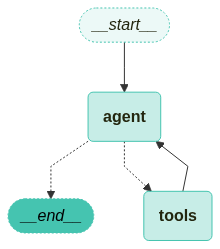

In [57]:
from langchain_teddynote.graphs import visualize_graph

visualize_graph(app)


In [58]:
# 실행 및 결과 확인
for chunk in app.stream(
    {"messages": [("human", "처음 5개의 소수를 출력하는 python code 를 작성해줘")]},
    stream_mode="values",
):
    # 마지막 메시지 출력
    chunk["messages"][-1].pretty_print()


================================ Human Message =================================

처음 5개의 소수를 출력하는 python code 를 작성해줘
================================== Ai Message ==================================
Tool Calls:
  python_code_interpreter (call_Y2dNCQOEXDi2WY07he2NtL2E)
 Call ID: call_Y2dNCQOEXDi2WY07he2NtL2E
  Args:
    code: def first_n_primes(n):
    primes = []
    num = 2  # Starting from the first prime number
    while len(primes) < n:
        is_prime = True
        for i in range(2, int(num**0.5) + 1):
            if num % i == 0:
                is_prime = False
                break
        if is_prime:
            primes.append(num)
        num += 1
    return primes

# Get the first 5 prime numbers
first_n_primes(5)
================================= Tool Message =================================
Name: python_code_interpreter

[2, 3, 5, 7, 11]
================================== Ai Message ==================================

처음 5개의 소수는 다음과 같습니다: [2, 3, 5, 7, 11]


In [47]:
# 검색 질문 수행
for chunk in app.stream(
    {"messages": [("human", "search google news about AI")]},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()


================================ Human Message =================================

search google news about AI
================================== Ai Message ==================================
Tool Calls:
  search_news (call_wgVECtKPM8OAKjVBAwe3EY5K)
 Call ID: call_wgVECtKPM8OAKjVBAwe3EY5K
  Args:
    query: AI
================================= Tool Message =================================
Name: search_news

[{"url": "https://news.google.com/rss/articles/CBMigwFBVV95cUxPMmRDbXdvaXNzbmxOc1hGWWNPTjdMeWxhNlRRNFVSZ2drel9Xb3FCWnZwSmxEYnIxdkJZaU1aV1JsVGIyT25YVVJXRGlTX0dlRlRCcUstY2V4V1pNU2pkZVBscGxDWnBaelhGMWtWQmdKTERER2JJaGFEMEE5d0J2N0Qwb9IBlwFBVV95cUxOakxuRy1QS29kVk9FbmRjVTJzb1dmLTdlSEgteElmRjdNQ24xb0Y5MUlqcERGSWtOa3hKZEpyZDd6NGpzT0dfVGhfa0VjaEFfOEZlcEh1cEZSVktranc4bmJZOC1IWVdLVHVGVGZFSkg4a3hYdm9PaVBUeTExU3dvSzl2aURyOHI1SVNfeEdCLUYyT01mX1d3?oc=5", "content": "AI가 통역 해주는 시대... 영어 공부 해? 말어? - 조선일보"}, {"url": "https://news.google.com/rss/articles/CBMiakFVX3lxTFBRblA0bGV3ZXByTUtURXJhTnMxV29Fbjlk

In [ ]:
# 도구 호출이 필요 없는 질문 수행
for chunk in app.stream(
    {"messages": [("human", "안녕? 반가워")]},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()

